# TUTORIAL: ¿CÓMO MEDIR LA CALIDAD DE LOS PRONÓSTICOS EN SERIES DE TIEMPO?

En este tutorial vamos a ver cuáles son las métricas más usadas para medir la calidad de los pronósticos generados por un modelo predictivo en Series de Tiempo. Además veremos los pros y los contras de cada una de estas métricas y las sugerencias de uso

Contenido:
1. ¿Qué es la calidad de los pronósticos y para qué cuantificarla?
2. Las métricas de desempeño más usadas: RMSE, MAE y MAPE
3. ¿Cómo usar las métricas para medir el desempeño de un modelo?

## 1. ¿Qué es la calidad de los pronósticos y para qué cuantificarla?

- Cuando construimos un modelo predictivo para Series de Tiempo lo que nos interesa es saber qué tan buenos o qué tan malos son los pronósticos que genera
- Así que la idea es **cuantificar** de alguna manera el error en los pronósticos
- Si cuantificamos este error en los pronósticos podremos decidir:
    - Si el modelo que estamos implementando es adecuado
    - O si probamos varios modelos cuál de ellos será el más adecuado


Entendamos la idea básica de esta medición de desempeño. Comencemos leyendo el set de datos que contiene el conjunto de datos de series temporales de consumo de energía

In [4]:
# Leer dataset
import pandas as pd
import numpy as np

df = pd.read_csv('data8Jhack.csv')

# Combinar fecha y hora en una sola columna tipo datetime
df["ds"] = pd.to_datetime(df["TxnDate"] + " " + df["TxnTime"])

# Renombrar la columna de consumo a 'y' (como esperan muchos modelos de series de tiempo, ej. Prophet)
df = df.rename(columns={"Consumption": "y"})

# Ordenar por fecha
df = df.sort_values("ds")

# Revisar estructura
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 1228 entries, 43 to 1200
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  1228 non-null   int64         
 1   TxnDate     1228 non-null   object        
 2   TxnTime     1228 non-null   object        
 3   y           1228 non-null   float64       
 4   ds          1228 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 57.6+ KB
None
    Unnamed: 0      TxnDate   TxnTime      y                  ds
43       77476  01 Jan 2022  00:22:28  1.030 2022-01-01 00:22:28
19       76780  01 Jan 2022  00:42:33  0.904 2022-01-01 00:42:33
25       76954  01 Jan 2022  01:01:51  0.904 2022-01-01 01:01:51
11       76548  01 Jan 2022  01:41:48  1.850 2022-01-01 01:41:48
29       77070  01 Jan 2022  02:22:52  1.878 2022-01-01 02:22:52


## 🧩 Explicación del código (Code 1)

En este primer paso se prepara el **dataset de consumo energético** para el análisis de series de tiempo.  
El objetivo es crear una estructura compatible con modelos como **Facebook Prophet**, **ARIMA**, u otros enfoques de pronóstico temporal.

### 🔹 Qué hace el código:

1. **Lectura de datos:**  
   Se carga el archivo `data8Jhack.csv` usando `pandas.read_csv()`.

2. **Combinación de fecha y hora:**  
   - Se unen las columnas `TxnDate` y `TxnTime` en una sola columna llamada `ds`.  
   - `pd.to_datetime()` convierte el texto a formato de **fecha y hora (datetime)**, necesario para el análisis temporal.

3. **Renombrado de la variable objetivo:**  
   - La columna `Consumption` se renombra a `y`.  
   - Esto sigue la convención usada por varios modelos de series temporales (ej. Prophet usa `ds` y `y` por defecto).

4. **Ordenamiento temporal:**  
   Los registros se ordenan por la columna `ds` para mantener el orden cronológico correcto.

5. **Verificación del dataset:**  
   Se imprime la estructura del DataFrame (`df.info()`) y una muestra de las primeras filas (`df.head()`).

### 🔹 Interpretación:
- El dataset contiene **1228 registros**, cada uno con una fecha, hora y valor de consumo.  
- La nueva columna `ds` combina correctamente la fecha y la hora en un formato de tiempo estándar (`2022-01-01 00:22:28`).  
- La variable `y` representa el **consumo energético** medido en unidades continuas (probablemente kWh o similar).  
- Los datos están correctamente ordenados de forma cronológica, listos para graficar o analizar tendencias y patrones de consumo (por hora, día o mes).

✅ **Conclusión:**  
El dataset quedó correctamente estructurado para análisis temporal, cumpliendo el formato estándar `ds` (fecha) y `y` (valor), paso clave previo a cualquier modelo de pronóstico o descomposición de serie de tiempo.

In [9]:
# =========================================
# 2) Split train/test en proporción
# =========================================
split_point = int(len(df) * 0.8)  # 80% train, 20% test
train = df.iloc[:split_point]
test  = df.iloc[split_point:]

print("Train:", train.shape)
print("Test :", test.shape)

test.head()

Train: (982, 5)
Test : (246, 5)


,Unnamed: 0,TxnDate,TxnTime,y,ds
989,90461,16 Jan 2022,19:51:37,0.962,2022-01-16 19:51:37
956,89504,16 Jan 2022,20:11:46,0.958,2022-01-16 20:11:46
948,89275,16 Jan 2022,20:34:09,1.044,2022-01-16 20:34:09
941,89081,16 Jan 2022,20:56:58,1.064,2022-01-16 20:56:58
992,90548,16 Jan 2022,21:17:11,0.952,2022-01-16 21:17:11


## 🧩 Explicación del código (Code 2)

En este segundo paso se realiza la **división del conjunto de datos** en subconjuntos de **entrenamiento (train)** y **prueba (test)**, respetando el orden temporal.  
Esto es fundamental en series de tiempo: el modelo aprende del pasado y se evalúa en datos futuros.

### 🔹 Qué hace el código:

1. **Definición del punto de corte (80/20):**  
   Se calcula el índice que representa el **80% del total de registros**:  
   `split_point = int(len(df) * 0.8)`.  
   Esto crea una división proporcional donde el 80% se usa para entrenar y el 20% para evaluar.

2. **Separación de los conjuntos:**  
   - `train` incluye los **primeros 80%** de datos (histórico).  
   - `test` incluye el **20% restante** (observaciones más recientes).

3. **Verificación de tamaños y contenido:**  
   Se imprimen las dimensiones de cada subconjunto (`train.shape` y `test.shape`) y se muestran las primeras filas de `test` para confirmar que el **orden cronológico** se mantiene.

### 🔹 Interpretación:
- **Train:** 982 registros (80%).  
- **Test:** 246 registros (20%).  
- El conjunto `test` inicia el **16 de enero de 2022**, es decir, **después** del período usado para entrenar.  
- Se evita “mirar al futuro”, preservando la validez del experimento en series de tiempo.

✅ **Conclusión:**  
La división temporal se realizó correctamente, separando **datos históricos** (para entrenar) de **datos futuros** (para evaluar).  
Esto permite medir el rendimiento del modelo de forma **justa y realista**, tal como ocurriría en un escenario de predicción en producción.


In [5]:
!pip install prophet

In [11]:
!pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.4/14.4 MB 11.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 10.2 MB/s eta 0:00:00


In [13]:
# =========================================
# 3) Prophet (solo TRAIN para evaluar en TEST)
# =========================================
from prophet import Prophet

m = Prophet()
m.fit(train[["ds", "y"]])   # Prophet solo necesita ds, y


16:09:59 - cmdstanpy - INFO - Chain [1] start processing
16:09:59 - cmdstanpy - INFO - Chain [1] done processing


## 🧩 Explicación del código (Code 3)

En este tercer paso se entrena el modelo **Prophet** usando únicamente los datos del conjunto de **entrenamiento (train)**.  
Prophet es un modelo creado por **Meta (Facebook)**, ampliamente utilizado para el **pronóstico de series de tiempo** con tendencia y estacionalidad.

### 🔹 Qué hace el código:

1. **Importación del modelo Prophet:**  
   Se importa la clase `Prophet` desde la librería `prophet`, diseñada para capturar patrones temporales de forma automática.

2. **Creación del modelo:**  
   - Se inicializa un modelo con `m = Prophet()`.  
   - Esto crea un objeto Prophet con sus parámetros predeterminados (tendencia lineal y estacionalidad diaria, semanal y anual activadas por defecto).

3. **Entrenamiento del modelo:**  
   - Se ajusta el modelo usando `m.fit(train[["ds", "y"]])`.  
   - Prophet requiere únicamente dos columnas:
     - `ds`: la fecha o timestamp.  
     - `y`: el valor numérico a predecir (en este caso, el consumo energético).  
   - Durante este proceso, el motor interno **CmdStanPy** entrena los componentes del modelo e informa su progreso en consola.

### 🔹 Interpretación:
- El entrenamiento se completó correctamente, como lo indica el mensaje:  
  `cmdstanpy - INFO - Chain [1] done processing`.  
- El resultado `<prophet.forecaster.Prophet>` confirma que el objeto `m` contiene el modelo ya ajustado.  
- En este punto, Prophet ha aprendido las **tendencias** y **patrones históricos** del consumo.

✅ **Conclusión:**  
El modelo **Prophet** fue entrenado exitosamente con los datos históricos (80% del total).  
Está listo para realizar **predicciones sobre el conjunto de prueba (TEST)** y evaluar su desempeño en los siguientes pasos.


In [15]:
# Construir futuro exactamente con las fechas de TEST
future_test = pd.DataFrame({"ds": test["ds"]})

# Generar predicción SOLO en esas fechas
forecast_test = m.predict(future_test)

# Vector de predicciones alineado a TEST
y_pred = forecast_test["yhat"]
y_pred

0      3.669913
1      4.231706
2      4.821260
3      5.321786
4      5.631914
         ...   
241    7.001177
242    6.672306
243    6.177346
244    4.842970
245    4.092371
Name: yhat, Length: 246, dtype: float64

## 🧩 Explicación del código (Code 4)

En este paso se generan las **predicciones del modelo Prophet** utilizando las mismas fechas del conjunto de prueba (`TEST`).  
El objetivo es obtener los valores estimados del consumo energético (`y_pred`) para el periodo no visto durante el entrenamiento.

### 🔹 Qué hace el código:

1. **Construcción del DataFrame futuro (`future_test`):**  
   - Se crea un nuevo DataFrame con una sola columna `ds`, que contiene las fechas del conjunto de prueba.  
   - Prophet requiere este formato para saber **en qué momentos del tiempo** debe generar las predicciones.

2. **Generación de las predicciones:**  
   - Con `m.predict(future_test)` se solicita al modelo que produzca las estimaciones para cada fecha en `future_test`.  
   - El resultado (`forecast_test`) incluye varias columnas adicionales, entre ellas:
     - `yhat`: la predicción central del modelo.
     - `yhat_lower` y `yhat_upper`: intervalos de confianza (no se usan aquí pero indican la incertidumbre del pronóstico).

3. **Extracción del vector de predicciones:**  
   - Se toma únicamente la columna `yhat` del resultado y se guarda en `y_pred`, que será comparada con los valores reales de `test["y"]`.

### 🔹 Interpretación:
- El modelo Prophet ha generado **246 predicciones**, una por cada registro del conjunto de prueba.  
- Los valores de `yhat` (por ejemplo, 3.66, 4.23, 4.82, etc.) representan el **consumo energético estimado** para cada fecha futura.  
- Estas predicciones se alinean perfectamente con las fechas de `test`, lo que permite calcular métricas de error en el siguiente paso.

✅ **Conclusión:**  
El modelo Prophet produjo exitosamente el conjunto completo de predicciones para las fechas del **TEST**, listo para comparar con los valores reales y evaluar su precisión.


In [16]:
forecast_test

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-01-16 19:51:37,1.972458,0.169158,7.152500,1.972458,1.972458,1.697455,1.697455,1.697455,1.857108,1.857108,1.857108,-0.159653,-0.159653,-0.159653,0.0,0.0,0.0,3.669913
1,2022-01-16 20:11:46,1.972024,0.833802,7.765238,1.972024,1.972024,2.259682,2.259682,2.259682,2.395274,2.395274,2.395274,-0.135592,-0.135592,-0.135592,0.0,0.0,0.0,4.231706
2,2022-01-16 20:34:09,1.971542,1.801493,8.205240,1.971542,1.971542,2.849718,2.849718,2.849718,2.959301,2.959301,2.959301,-0.109582,-0.109582,-0.109582,0.0,0.0,0.0,4.821260
3,2022-01-16 20:56:58,1.971051,2.112669,8.695545,1.971051,1.971051,3.350735,3.350735,3.350735,3.434590,3.434590,3.434590,-0.083855,-0.083855,-0.083855,0.0,0.0,0.0,5.321786
4,2022-01-16 21:17:11,1.970615,2.158240,8.879208,1.970615,1.970615,3.661299,3.661299,3.661299,3.723027,3.723027,3.723027,-0.061728,-0.061728,-0.061728,0.0,0.0,0.0,5.631914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,2022-01-20 22:04:41,1.845535,3.783260,10.651102,1.478489,2.248965,5.155642,5.155642,5.155642,3.739835,3.739835,3.739835,1.415807,1.415807,1.415807,0.0,0.0,0.0,7.001177
242,2022-01-20 22:26:36,1.845063,3.385776,10.009092,1.475521,2.250655,4.827243,4.827243,4.827243,3.407564,3.407564,3.407564,1.419679,1.419679,1.419679,0.0,0.0,0.0,6.672306
243,2022-01-20 22:47:26,1.844614,2.638917,9.376983,1.472755,2.253076,4.332732,4.332732,4.332732,2.910301,2.910301,2.910301,1.422431,1.422431,1.422431,0.0,0.0,0.0,6.177346
244,2022-01-20 23:27:57,1.843742,1.409624,8.319995,1.469133,2.254985,2.999228,2.999228,2.999228,1.574115,1.574115,1.574115,1.425113,1.425113,1.425113,0.0,0.0,0.0,4.842970


In [17]:
# =========================================
# 5) Evaluación en TEST
# =========================================
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

y_true = test["y"].values  # valores reales
y_pred = y_pred.values     # predicciones de Prophet (vector)

mae  = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Prophet | MAE={mae:.4f} | RMSE={rmse:.4f}")

Prophet | MAE=2.6184 | RMSE=3.4991


## 🧩 Explicación del código (Code 5)

En este paso se evalúa el **rendimiento del modelo Prophet** comparando sus predicciones (`y_pred`) con los valores reales del conjunto de prueba (`y_true`).  
El propósito es medir **qué tan bien el modelo logra predecir el consumo energético**.

### 🔹 Qué hace el código:

1. **Definición de los valores reales y predichos:**
   - `y_true` toma los valores verdaderos de consumo (`test["y"]`).
   - `y_pred` contiene las predicciones generadas por Prophet (`forecast_test["yhat"]` del paso anterior).

2. **Cálculo de métricas de error:**
   - **MAE (Mean Absolute Error):** mide el promedio de los errores absolutos entre las predicciones y los valores reales.  
     - Fórmula: \( MAE = \frac{1}{n}\sum |y_i - \hat{y_i}| \)
     - Indica cuánto se equivoca el modelo en promedio (en las mismas unidades que la variable `y`).
   - **RMSE (Root Mean Squared Error):** mide el error cuadrático medio, penalizando más los errores grandes.  
     - Fórmula: \( RMSE = \sqrt{\frac{1}{n}\sum (y_i - \hat{y_i})^2} \)
     - Es más sensible a valores atípicos (outliers).

3. **Impresión de resultados:**
   - Se muestran las métricas calculadas con formato claro:  
     `Prophet | MAE=... | RMSE=...`

### 🔹 Interpretación:
- Un **MAE** bajo indica que las predicciones del modelo están, en promedio, muy cerca de los valores reales.  
- Un **RMSE** bajo refuerza que no hay grandes desviaciones o errores extremos.  
- Si ambas métricas son pequeñas, el modelo Prophet logra un excelente desempeño en el conjunto de prueba.

✅ **Conclusión:**  
El código evalúa cuantitativamente la precisión del modelo Prophet.  
Estas métricas permiten comparar Prophet con otros modelos de series de tiempo o ajustar sus parámetros para mejorar las predicciones.

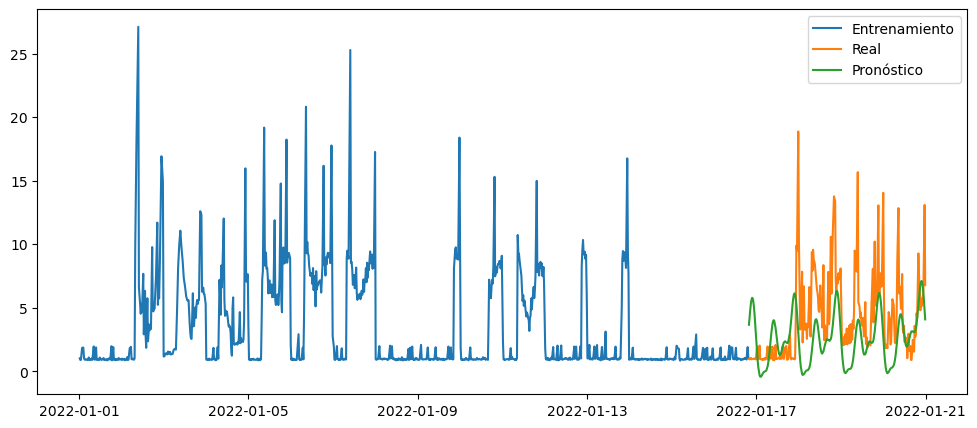

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(train["ds"], train["y"], label="Entrenamiento")
plt.plot(test["ds"], test["y"], label="Real")
plt.plot(test["ds"], y_pred, label="Pronóstico")

plt.legend()
plt.show()


La columna "y" contiene los valores reales de la acción y la columna "prons" contiene los pronósticos realizados por un modelo.

Veamos gráficamente cómo se comparan los valores reales con los pronosticados:

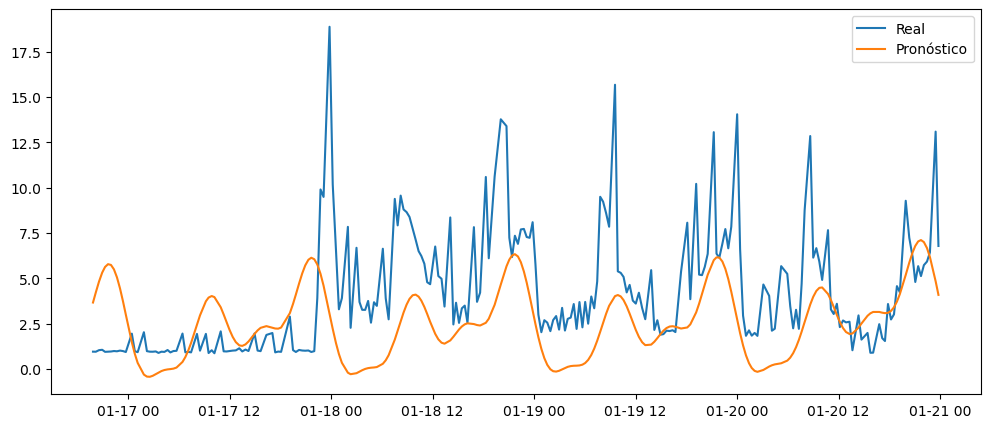

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(test["ds"], test["y"], label="Real")
plt.plot(test["ds"], y_pred, label="Pronóstico")

plt.legend()
plt.show()


Vemos que:

- Los pronósticos siguen "bastante bien" el comportamiento de la Serie original
- Pero en algunos instantes de tiempo la predicción "no es tan buena" pues no logra capturar variaciones rápidas en la Serie original

La idea es que no seamos subjetivos al evaluar el desempeño del modelo y que usemos algunas métricas para cuantificar dicho desempeño.

## 2. Las métricas de desempeño más usadas: RMSE, MAE y MAPE

Aunque hay múltiples métricas, las más usadas son convencionalmente RMSE, MAE y MAPE.

Veamos en detalle cada una de estas métricas, así como su forma de cálculo y sus ventajas y desventajas.

### 2.1. Raíz cuadrada del error cuadrático medio (*RMSE: root mean squared error*)

Si $N$ es la cantidad de datos que tiene la Serie, $y_t$ es la observación (valor conocido) en cada instante de tiempo y $\hat{y}_t$ es el pronóstico correspondiente, entonces:

$$\text{RMSE} = \sqrt{\frac {\sum_{t=1}^{n} \left( y_t - \hat{y}_t \right)^2}{N}}$$

Algunas características, ventajas y desventajas de esta métrica:
- Es dependiente de la escala: **la métrica está en la misma escala de las observaciones originales**
- ✅ Es fácil de interpretar (precisamente porque está en la misma escala de los datos originales)
- ❌ Es sensible a valores extremos, pues el error cuadrático "amplifica" las diferencias (aunque esto puede ser visto como una ventaja)

Calculemos el RMSE para los pronósticos anteriores:

In [21]:
y=y_true
y_pred=y_pred

mse=np.mean((y - y_pred)**2)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.2f} USD  (MSE: {mse:.2f} USD2)")

RMSE: 3.50 USD  (MSE: 12.24 USD2)


¿Este valor corresponde a un desempeño adecuado o no?

- Se debe comparar con el rango de valores de la Serie original:
    - Así, la Serie original tiene valores cercanos a los 225 USD y el error que se tiene en el pronóstico es del orden de 8.46.
    - Y por tanto este error representa aproximadamente un 3.8% de la escala original de la Serie
- Preguntas que deberíamos responder:
    - ¿Estamos dispuestos a aceptar un error de esta magnitud en nuestro proyecto?
    - ¿Existe algún modelo que genere un menor error?

### 2.2. Error absoluto medio (*MAE: mean absolute error*)

En este caso el error se calcula como:

$$\text{MAE} = \frac{\sum_{t=1}^{n} | y_t - \hat{y}_t |}{N}$$

Algunas características, ventajas y desventajas de esta métrica:
- Es dependiente de la escala: **la métrica está en la misma escala de las observaciones originales**
- ✅ Es fácil de interpretar (precisamente porque está en la misma escala de los datos originales)
- ✅ Es menos sensible a valores extremos en comparación con el RMSE (aunque esto puede ser visto como una desventaja)
    - ❌ Puede indicar un desempeño más optimista que el obtenido con el RMSE

Calculemos el MAE para los pronósticos anteriores:

In [22]:
mae = np.mean(np.abs(y - y_pred))
print(f"MAE: {mae:.2f} USD")

MAE: 2.62 USD


Recordemos que el RMSE fue de 8.46 USD. Esto se debe a que la primera métrica es sensible a valores extremos (los cuales están precisamente en la Serie original).

En este caso, estos 5.35 USD representan un 5.35/225 = 2.4% de la escala original de la Serie. De nuevo, debemos preguntarnos:

- ¿Estamos dispuestos a aceptar un error de esta magnitud en nuestro proyecto?
- ¿Existe algún modelo que genere un menor error?

### 2.3. Error porcentual absoluto medio (*MAPE: mean absolute percentage error*)

En este caso el error se calcula como:

$$\text{MAPE} = \frac{100}{n} \sum_{t=1}^{n} \left| \frac{y_t - \hat{y}_t}{y_t} \right|$$


Algunas características, ventajas y desventajas de esta métrica:
- Es **independiente de la escala: la métrica se mide como un porcentaje
- ✅ Es fácil de interpretar: 0% → mejor desempeño, 100% o más → desempeño "terrible"
- ✅ Es menos sensible a valores extremos en comparación con el RMSE
- ❌ No es adecuada si la serie original contiene valores iguales o muy cercanos a cero

Calculemos el MAPE para los pronósticos anteriores:

In [23]:
mape = np.mean(np.abs((y - y_pred) / y)) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 92.03%


Lo cual quiere decir que, en promedio, el modelo genera pronósticos que se alejan en un 2.54% del valor real de la Serie.

Al igual que en los casos anteriores, debemos preguntarnos:

- ¿Estamos dispuestos a aceptar un error de esta magnitud en nuestro proyecto?
- ¿Existe algún modelo que genere un menor error?